In [1]:
import os
import re
from typing import List

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from nltk import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC                         # Высокий шанс переобучения
from sklearn.neighbors import KNeighborsClassifier  # Плохо работает на данных большой размерности из-за проклятия размерности
from sklearn.naive_bayes import MultinomialNB       # Подразумевается, что признаки независимые, но для текста это неверно
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from nltk.corpus import stopwords
import pymorphy3

from catboost import CatBoostClassifier

import warnings 
warnings.simplefilter('ignore')

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\423\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df_train = pd.read_csv("../data/my_dataset.csv")

In [3]:
df_train = df_train.dropna(axis=0, how='any')
df_train.head()

,text,style
0,Как целостная система знаний о растениях ботан...,2
1,\r\n Содержание\r\n Основные этапы развития бо...,2
2,) в пятой книге «Истории животных» (лат. Hist...,2
3,"Виммером. Из них\r\n можно видеть, что Арист...",2
4,"Он\r\n писал, например, что в отношении некот...",2


In [4]:
df_train[df_train.isna().any(axis=1)]

,text,style


In [5]:
style = df_train["style"].drop_duplicates().values
category = dict()
for i in range(len(style)):
    category[style[i]] = i 

style
0    889
2    651
1    359
Name: count, dtype: int64

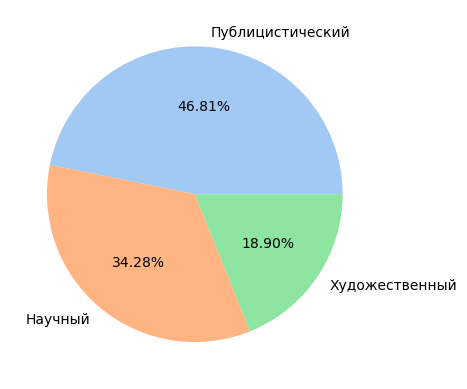

In [6]:
cnts = df_train["style"].value_counts()
cnts
colors = sns.color_palette('pastel')[ 0:5 ]
plt.pie(cnts, labels=["Публицистический", "Научный", "Художественный"], colors=colors, autopct="%1.2f%%")
cnts

In [7]:
stop_words = set(stopwords.words('russian'))

def preprocess_text(text: str) -> List[str]:
    return re.sub(r"[^\w\s]+", '', text).lower().split()

def preprocess_porter_stem(text: str) -> str:
    prep_text = preprocess_text(text)
    stemmer = PorterStemmer()
    singles = [stemmer.stem(x) for x in prep_text if x not in stop_words]
    return ' '.join(singles)

def preprocess_snowball_stem(text: str) -> str:
    prep_text = preprocess_text(text)
    stemmer = SnowballStemmer("russian")
    singles = [stemmer.stem(x) for x in prep_text if x not in stop_words]
    return ' '.join(singles)

def preprocess_wordnet_lem(text: str) -> str:
    prep_text = preprocess_text(text)
    lemmatizer = WordNetLemmatizer()
    singles = [lemmatizer.lemmatize(x) for x in prep_text if x not in stop_words]
    return ' '.join(singles)

def preprocess_pymrophy(text: str) -> str:
    prep_text = preprocess_text(text)
    morph = pymorphy3.MorphAnalyzer()
    singles = [morph.parse(x)[0].normal_form for x in prep_text if x not in stop_words]
    return ' '.join(singles)

In [8]:
df_train['porter'] = df_train['text'].map(lambda x: preprocess_porter_stem(x))
df_train['snowball'] = df_train['text'].map(lambda x: preprocess_snowball_stem(x))
df_train['wordnet'] = df_train['text'].map(lambda x: preprocess_wordnet_lem(x))
df_train['pymorphy'] = df_train['text'].map(lambda x: preprocess_pymrophy(x))

In [9]:
df_train.head()

,text,style,porter,snowball,wordnet,pymorphy
0,Как целостная система знаний о растениях ботан...,2,целостная система знаний растениях ботаника оф...,целостн систем знан растен ботаник оформ xviix...,целостная система знаний растениях ботаника оф...,целостный система знание растение ботаника офо...
1,\r\n Содержание\r\n Основные этапы развития бо...,2,содержание основные этапы развития ботаники ти...,содержан основн этап развит ботаник титульн ли...,содержание основные этапы развития ботаники ти...,содержание основной этап развитие ботаник титу...
2,) в пятой книге «Истории животных» (лат. Hist...,2,пятой книге истории животных лат historia anim...,пят книг истор животн лат historia animalium у...,пятой книге истории животных лат historia anim...,пятый книга история животное лата historia ani...
3,"Виммером. Из них\r\n можно видеть, что Арист...",2,виммером видеть аристотель признавал существов...,виммер видет аристотел признава существован дв...,виммером видеть аристотель признавал существов...,виммер видеть аристотель признавать существова...
4,"Он\r\n писал, например, что в отношении некот...",2,писал например отношении некоторых обитателей ...,писа например отношен некотор обитател мор тру...,писал например отношении некоторых обитателей ...,писать например отношение некоторый обитатель ...


In [10]:
train, test = train_test_split(df_train, test_size=0.35, stratify=df_train["style"], shuffle=True, random_state=57)
test, val = train_test_split(test, test_size=0.5, random_state=52)

In [11]:
train.head()

,text,style,porter,snowball,wordnet,pymorphy
37,"Те гипотезы,\r\n которые описывают совокупнос...",2,те гипотезы которые описывают совокупность наб...,те гипотез котор описыва совокупн наблюда факт...,те гипотезы которые описывают совокупность наб...,тот гипотеза который описывать совокупность на...
959,"\r\n Вонмигласов сидит минуту неподвижно, слов...",0,вонмигласов сидит минуту неподвижно словно чув...,вонмиглас сид минут неподвижн словн чувств оше...,вонмигласов сидит минуту неподвижно словно чув...,вонмиглас сидеть минута неподвижно словно чувс...
1803,"Против всех кандидатовпроголосовало 2,76% изб...",1,против кандидатовпроголосовало 276 избирателей...,прот кандидатовпроголосова 276 избирател выбор...,против кандидатовпроголосовало 276 избирателей...,против кандидатовпроголосовать 276 избиратель ...
598,Суперанской и А. В. Сусловой за 1988\r\n го...,2,суперанской сусловой 1988 год многие отмечалис...,суперанск суслов 1988 год мног отмеча им огран...,суперанской сусловой 1988 год многие отмечалис...,суперанский суслов 1988 год многие отмечаться ...
64,"В Великобритании, например,\r\n роль Академии...",2,великобритании например роль академии играет к...,великобритан например рол академ игра королевс...,великобритании например роль академии играет к...,великобритания например роль академия играть к...


In [12]:
test.head()

,text,style,porter,snowball,wordnet,pymorphy
528,\r\n Одновременно с распространением имён прои...,2,одновременно распространением имён проистекала...,одновремен распространен им проистека народн а...,одновременно распространением имён проистекала...,одновременно распространение имя проистекать н...
620,"\r\n Распространяясь через ФСР, электроны с\r\...",2,распространяясь фср электроны антипараллельным...,распростран фср электрон антипараллельн направ...,распространяясь фср электроны антипараллельным...,распространяться фср электрон антипараллельный...
834,"\r\n Противоположная резная дверь открылась, в...",0,противоположная резная дверь открылась вошел т...,противоположн резн двер откр вошел тяпнут оказ...,противоположная резная дверь открылась вошел т...,противоположный резной дверь открыться войти т...
725,\r\n Наконец даже газеты заговорили об этих яв...,0,газеты заговорили этих явлениях сям стали появ...,газет заговор эт явлен сям стал появля популяр...,газеты заговорили этих явлениях сям стали появ...,газета заговорить этот явление сям стать появл...
1806,"Двум другим прохожим-израильтянам, получившим...",1,двум другим прохожимизраильтянам получившим ле...,двум друг прохожимизраильтян получ легк травм ...,двум другим прохожимизраильтянам получившим ле...,два другой прохожимизраильтянин получить лёгки...


In [13]:
val.head()

,text,style,porter,snowball,wordnet,pymorphy
1272,Крик и шум сделались общими. \r\n Кошевой хот...,0,крик шум сделались общими кошевой хотел говори...,крик шум сдела общ кошев хотел говор зна разъя...,крик шум сделались общими кошевой хотел говори...,крик шум сделаться общий кошев хотеть говорить...
1106,")] на лестнице, приговаривая: ""Вот тебе, Пеппе...",0,лестнице приговаривая тебе пеппе молился свято...,лестниц приговарив теб пепп мол свят панкрат т...,лестнице приговаривая тебе пеппе молился свято...,лестница приговаривать ты пеппа молиться свято...
759,"Хоть и лопают богато, и все с красным вином. ...",0,лопают богато красным вином прибежит машинисто...,лопа богат красн вин прибеж машинисточк четыр ...,лопают богато красным вином прибежит машинисто...,лопать богато красный вино прибежать машинисто...
1455,". \r\n Скажет вам старик матрос, оборотясь наз...",0,скажет старик матрос оборотясь назад поверить ...,скажет старик матрос оборот назад повер направ...,скажет старик матрос оборотясь назад поверить ...,сказать старик матрос оборотиться назад повери...
82,Основатель Берлинской Академии наук Лейбниц в...,2,основатель берлинской академии наук лейбниц па...,основател берлинск академ наук лейбниц памятн ...,основатель берлинской академии наук лейбниц па...,основатель берлинский академия наука лейбниц п...


In [14]:
params = {
    'max_depth': [5, 20, 50, 100],
    'min_samples_split': [5, 10, 30, 50, 100],
    'min_samples_leaf': [5, 10, 30, 50, 100],
}
dec_tree_param = {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 100}

In [15]:
params_rt = {'n_estimators': [100, 300, 500],
             'max_depth': [50, 100, 200, 250],
             'min_samples_split': [25, 100, 200],
             'min_samples_leaf': [10, 30, 100]}

random_forest_param = {'n_estimators': 300,
 'min_samples_split': 25,
 'min_samples_leaf': 10,
 'max_depth': 100}

In [16]:
sample = df_train.sample(df_train.shape[0] // 10)
train_smaller, test_smaller = train_test_split(sample, test_size=0.3, stratify=sample["style"], shuffle=True, random_state=57)

tfidf = TfidfVectorizer(preprocessor=preprocess_snowball_stem)

x_news_train = tfidf.fit_transform(train_smaller['text'])
x_news_test = tfidf.transform(test_smaller['text'])

y_train = train_smaller["style"]
y_test = test_smaller["style"]

model = LogisticRegression(max_iter=300)
model_score = cross_val_score(model, x_news_train, y_train, cv=5, scoring=make_scorer(f1_score, average='macro'))
model_score

array([0.43121693, 0.51262626, 0.38241758, 0.42577031, 0.53257432])

In [17]:
from scipy.stats import mannwhitneyu

def find_best_model(x_train_df: pd.DataFrame, y_train_df: pd.DataFrame, x_test_df: pd.DataFrame, to_pipeline: List):
    best_score = None
    best_model = None
    for item in to_pipeline:
        prep = item[1][1]
        m = item[2][1]
        x_news_train = prep.fit_transform(x_train_df[item[0][0]])
        x_news_test = prep.transform(x_test_df[item[0][0]])
        score = cross_val_score(m, x_news_train, y_train_df, cv=10, scoring=make_scorer(f1_score, average='macro'))
        if best_score is None:
            best_score = score
            best_model = item
            print(f"Best model: {best_model[0][0]}-{best_model[1][0]}-{best_model[2][0]}")
        else:
            p = mannwhitneyu(np.array(best_score), np.array(score), alternative='less').pvalue
            if p < 0.05:
                best_score = score
                best_model = item
                print(f"Best model: {best_model[0][0]}-{best_model[1][0]}-{best_model[2][0]}")
    return best_model, best_score

In [18]:
def train_and_test_model(x_train_df: pd.DataFrame, y_train_df: pd.DataFrame, x_test_df: pd.DataFrame, y_test_df: pd.DataFrame, to_pipeline: List):
    for item in to_pipeline:
        pipe = Pipeline(item[1:])
        x_train_now = x_train_df[item[0][0]]
        x_test_now = x_test_df[item[0][0]]
        pipe.fit(x_train_now, y_train_df)
        print(f"{item[0][0]}+{item[1][0]}+{item[2][0]}")
        y_pred = pipe.predict(x_train_now)
        print(f"Train: {f1_score(y_train_df, y_pred, average='macro')}")
        y_pred = pipe.predict(x_test_now)
        print(f"Test: {f1_score(y_test_df, y_pred, average='macro')}")
        df = pd.DataFrame(data=classification_report(y_test_df, y_pred, output_dict=True))
        df.rename(mapper= lambda x: style[int(x)] if x not in ['accuracy', 'macro avg', 'weighted avg'] else x, axis='columns', inplace=True)
        print(df)
        conf_m = confusion_matrix(y_test_df, y_pred)
        cm_display = sns.heatmap(conf_m, cmap="afmhot", xticklabels=style, yticklabels=style)
        cm_display.plot()
        plt.rcParams['xtick.major.pad']= 10
        plt.rcParams['ytick.major.pad']= 10
        plt.xticks(rotation=90)
        plt.show()

In [19]:
preprocess = [('porter', preprocess_porter_stem), ('snowball', preprocess_snowball_stem), ('wordnet', preprocess_wordnet_lem), ('pymorphy', preprocess_pymrophy)]
vectorizers = [('bow', CountVectorizer()), ('tfidf', TfidfVectorizer())]
all_log_reg = []

for p in preprocess:
    for v in vectorizers:
        all_log_reg.append([p, v, ('logreg', LogisticRegression(max_iter=300))])

log_reg_model, log_reg_score = find_best_model(train, train["style"], test, all_log_reg)
print(log_reg_score)
print(log_reg_model)

Best model: porter-bow-logreg
Best model: snowball-bow-logreg
[0.94557549 0.87658736 0.9213325  0.9293947  0.90511132 0.94248366
 0.98292681 0.93763898 0.89491988 0.97023478]
[('snowball', <function preprocess_snowball_stem at 0x00000132396F1EE0>), ('bow', CountVectorizer()), ('logreg', LogisticRegression(max_iter=300))]


In [20]:
all_dec_tree = []

for p in preprocess:
    for v in vectorizers:
        all_dec_tree.append([p, v, ('dectree', DecisionTreeClassifier(**dec_tree_param))])

dec_tree_model, dec_tree_score = find_best_model(train, train["style"], test, all_dec_tree)
print(dec_tree_score)
print(dec_tree_model)

Best model: porter-bow-dectree
Best model: pymorphy-tfidf-dectree
[0.69569521 0.70885547 0.76369168 0.77860697 0.7191698  0.75936512
 0.86585675 0.68185148 0.74074074 0.70195268]
[('pymorphy', <function preprocess_pymrophy at 0x00000132396F2700>), ('tfidf', TfidfVectorizer()), ('dectree', DecisionTreeClassifier(max_depth=100, min_samples_leaf=10,
                       min_samples_split=100))]


In [21]:
all_rand_forest = []

for p in preprocess:
    for v in vectorizers:
        all_rand_forest.append([p, v, ('rf', RandomForestClassifier(**random_forest_param))])

rand_forest_model, rand_forest_score = find_best_model(train, train["style"], test, all_rand_forest)
print(rand_forest_score)
print(rand_forest_model)

Best model: porter-bow-rf
Best model: snowball-bow-rf
[0.59128499 0.62228488 0.66573427 0.54396343 0.58407348 0.64419777
 0.72608198 0.60261796 0.57739446 0.65157055]
[('snowball', <function preprocess_snowball_stem at 0x00000132396F1EE0>), ('bow', CountVectorizer()), ('rf', RandomForestClassifier(max_depth=100, min_samples_leaf=10, min_samples_split=25,
                       n_estimators=300))]


snowball+bow+logreg
Train: 1.0
Test: 0.9554748062015502
                    2          0           1  accuracy   macro avg  \
precision    0.945122   1.000000    0.962963  0.960843    0.969362   
recall       0.993590   0.869565    0.971963  0.960843    0.945039   
f1-score     0.968750   0.930233    0.967442  0.960843    0.955475   
support    156.000000  69.000000  107.000000  0.960843  332.000000   

           weighted avg  
precision      0.962277  
recall         0.960843  
f1-score       0.960323  
support      332.000000  


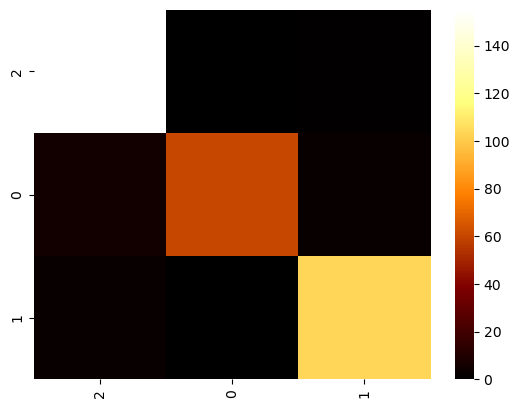

In [22]:
train_and_test_model(train, train["style"], test, test["style"], [log_reg_model])

pymorphy+tfidf+dectree
Train: 0.8078676164169151
Test: 0.7596683312314196
                    2          0           1  accuracy   macro avg  \
precision    0.827381   0.734694    0.782609  0.798193    0.781561   
recall       0.891026   0.521739    0.841121  0.798193    0.751295   
f1-score     0.858025   0.610169    0.810811  0.798193    0.759668   
support    156.000000  69.000000  107.000000  0.798193  332.000000   

           weighted avg  
precision      0.793688  
recall         0.798193  
f1-score       0.791296  
support      332.000000  


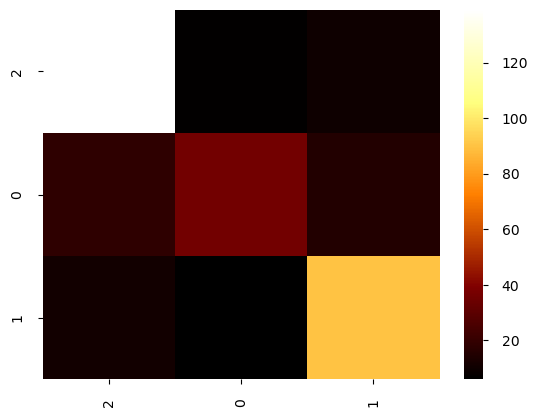

In [23]:
train_and_test_model(train, train["style"], test, test["style"], [dec_tree_model])

snowball+bow+rf
Train: 0.7378378866563163
Test: 0.7078268788414186
                    2          0           1  accuracy   macro avg  \
precision    0.690265   1.000000    0.887500  0.762048    0.859255   
recall       1.000000   0.376812    0.663551  0.762048    0.680121   
f1-score     0.816754   0.547368    0.759358  0.762048    0.707827   
support    156.000000  69.000000  107.000000  0.762048  332.000000   

           weighted avg  
precision      0.818205  
recall         0.762048  
f1-score       0.742269  
support      332.000000  


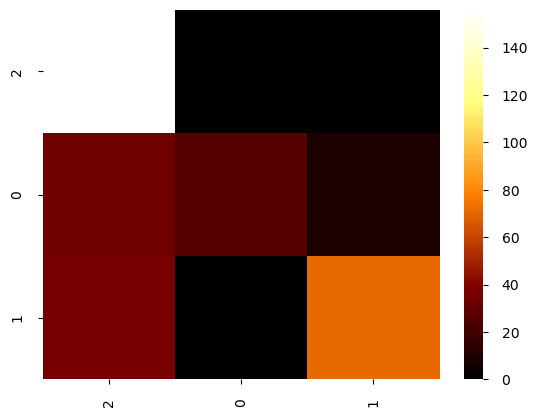

In [24]:
train_and_test_model(train, train["style"], test, test["style"], [rand_forest_model])

porter+bow+cb
Train: 0.9880350099676153
Test: 0.7951560316721006
                    2          0           1  accuracy   macro avg  \
precision    0.741463   0.954545    0.915663  0.813253    0.870557   
recall       0.974359   0.608696    0.710280  0.813253    0.764445   
f1-score     0.842105   0.743363    0.800000  0.813253    0.795156   
support    156.000000  69.000000  107.000000  0.813253  332.000000   

           weighted avg  
precision      0.841891  
recall         0.813253  
f1-score       0.808013  
support      332.000000  


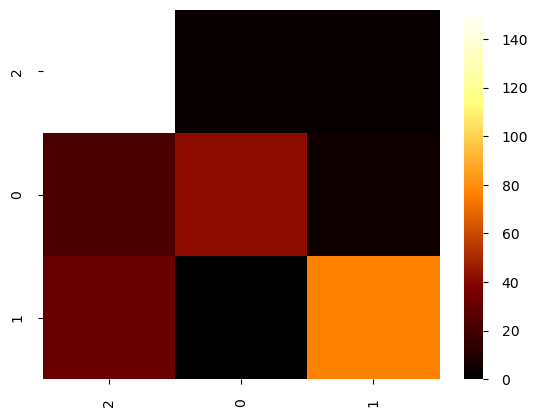

In [25]:
catboost_arr = [('porter', preprocess_porter_stem), ('bow', CountVectorizer()), ('cb', CatBoostClassifier(verbose=False, iterations=500))]

train_and_test_model(train, train["style"], test, test["style"], [catboost_arr])